In [12]:
import json
from tree import *
from load_blosum import load_blosum
import numpy as np
f = open("organisms.json", "r")
ORGANISMS = json.load(f)
f.close()
BLOSUM50_SCORES = load_blosum("blosum50.bla")
BLOSUM62_SCORES = load_blosum("blosum62.bla")

# sys.setrecursionlimit(100)
# May be needed if you choose to take a recursive approach

# Reading Blosum Tables

Now that we have an alphabet for DNA strings and an algorithm to compare them, we can define meaningful costs for matchings and substitutions of amino acids. We will be using tables obtained from an experimental, data-driven technique that constructs a "Blocks Substitution Matrix," or "BLOSUM" for short, as described in [this paper](http://146.6.100.192/users/BCH339N_2018/BLOSUM62Miscalculations.pdf). In a nutshell, the technique computes statistical likelihoods that substitutions take place by examining many well-aligned sequences.

There are different similarity thresholds at which BLOSUM tables can be constructed, and higher numbers mean that we're more conservative in which symbols we allow to be aligned. In assignment 5, we'll be considering BLOSUM50 and BLOSUM62, as obtained from [this link](https://ftp.ncbi.nih.gov/repository/blocks/unix/blosum/blosum.tar.Z). Click the "show/hide" buttons to view each of these below. You'll notice that we get a positive score when matching an amino acid to itself, and a negative score when swapping amino acids and when deleting them (matching to a *), so this is compatible with Needleman-Wunsch. You'll also notice that this matrix is symmetric (e.g. A to D and D to A are both -2), so we will only be storing the non-redundant parts in a lookup dictionary. 

In [13]:
BLOSUM62_SCORES

{'AA': 4,
 'AR': -1,
 'RA': -1,
 'AN': -2,
 'NA': -2,
 'AD': -2,
 'DA': -2,
 'AC': 0,
 'CA': 0,
 'AQ': -1,
 'QA': -1,
 'AE': -1,
 'EA': -1,
 'AG': 0,
 'GA': 0,
 'AH': -2,
 'HA': -2,
 'AI': -1,
 'IA': -1,
 'AL': -1,
 'LA': -1,
 'AK': -1,
 'KA': -1,
 'AM': -1,
 'MA': -1,
 'AF': -2,
 'FA': -2,
 'AP': -1,
 'PA': -1,
 'AS': 1,
 'SA': 1,
 'AT': 0,
 'TA': 0,
 'AW': -3,
 'WA': -3,
 'AY': -2,
 'YA': -2,
 'AV': 0,
 'VA': 0,
 'AB': -2,
 'BA': -2,
 'AZ': -1,
 'ZA': -1,
 'AX': 0,
 'XA': 0,
 'A': -4,
 'RR': 5,
 'RN': 0,
 'NR': 0,
 'RD': -2,
 'DR': -2,
 'RC': -3,
 'CR': -3,
 'RQ': 1,
 'QR': 1,
 'RE': 0,
 'ER': 0,
 'RG': -2,
 'GR': -2,
 'RH': 0,
 'HR': 0,
 'RI': -3,
 'IR': -3,
 'RL': -2,
 'LR': -2,
 'RK': 2,
 'KR': 2,
 'RM': -1,
 'MR': -1,
 'RF': -3,
 'FR': -3,
 'RP': -2,
 'PR': -2,
 'RS': -1,
 'SR': -1,
 'RT': -1,
 'TR': -1,
 'RW': -3,
 'WR': -3,
 'RY': -2,
 'YR': -2,
 'RV': -3,
 'VR': -3,
 'RB': -1,
 'BR': -1,
 'RZ': 0,
 'ZR': 0,
 'RX': -1,
 'XR': -1,
 'R': -4,
 'NN': 6,
 'ND': 1,
 'DN': 1,
 'NC': -

 # Needleman-Wunsch algorithm
 Since DNA is a string, we can compare two DNA sequences with string comparison methods, but when comparing the sequences across organisms, the technique needs to account for mutations that have occurred over evolutionary histories, including additions, deletions, and substitutions of individual amino acids. We've discussed dynamic programing techniques for computing the string edit distance, which accounts for such mutations. However, it models a unit cost for an addition, deletion, and substitution alike, and there are biological reasons that we may want to have costs that are more less expensive for certain amino acid edits, as explained below.

To address the need for variable costs, there is a variant of edit distance known as Needleman-Wunsch, in which the costs can change depending on what characters are involved. By convention, we actually switch from a "minimizing cost" mindset to a maximizing score mindset. Given a string of length M and a string of length N, the optimal Needleman-Wunsch score can be computed in O(MN) time using a similar dynamic programming algorithm to edit distance. In particular, to match a string of length M to a string of length N, the vanilla version proceeds by filling in an (M+1) x (N+1) table S storing all solutions to sub-problems, using the following recurrence relation, where di and dj refer to the cost of deleting the ith and jth characters of the first and second strings, respectively, and cij refers to the cost of substituting the ith character of the first string for the jth character of the second string (and everything is 0-indexed):

![equation](imgs/NeedWunchEqnSmall.png)

To get the final Needleman-Wunsch score, you then take the sum of the diagonal of the created similarity table.


In [14]:
def needleman_wunsch(species1, species2, blosum_scores):
    """Returns the needleman wunch scores of the two strings using the provided swapping scores"""
    similarity = [[None for j in range(len(species1)+1)] for i in range(len(species2)+1)]
    for i in range(len(similarity)):
        for j in range(len(similarity[i])):
            if i == j and j == 0:
                similarity[i][j] = 0
            elif i == 0:
                similarity[i][j] = similarity[0][j-1] + blosum_scores[species1[j-1]]
            elif j == 0:
                similarity[i][j] = similarity[i-1][0] + blosum_scores[species2[i-1]]
            else:
                # Remember you can use the max() function to find the maximum favlue among its parameteres
                similarity[i][j] = max(similarity[i][j-1] + blosum_scores[species1[j-1]],  similarity[i-1][j] + blosum_scores[species2[i-1]],  similarity[i-1][j-1] + blosum_scores["".join(sorted([species1[j-1],species2[i-1]]))])
    
    # CHECKING IF ALL VALUES WERE REPLACED
    for i in similarity:
        if None in i:
            raise Exception("Similarity matrix is not fully filled out")
    # print("\n".join([str(i) for i in similarity]))

    score  = similarity[-1][-1]

    return int(score)

if needleman_wunsch(ORGANISMS["Dog"], ORGANISMS["Hyaena"], BLOSUM62_SCORES) != 1375:
    raise Exception(f"Dog-Hyaena similarity should be 1375, is {needleman_wunsch(ORGANISMS["Dog"], ORGANISMS["Hyaena"], BLOSUM62_SCORES)}")
elif needleman_wunsch(ORGANISMS["Domestic Cat"], ORGANISMS["Cougar"], BLOSUM62_SCORES) != 1427:
    raise Exception(f"Cat-Cougar similarity should be 1427, is {needleman_wunsch(ORGANISMS["Domestic Cat"], ORGANISMS["Cougar"], BLOSUM62_SCORES)}")
else:
    print("Dog-Hyaena similarity is "+str(needleman_wunsch(ORGANISMS["Dog"], ORGANISMS["Hyaena"], BLOSUM62_SCORES)))
    print("Cat-Cougar similarity is "+str(needleman_wunsch(ORGANISMS["Domestic Cat"], ORGANISMS["Cougar"], BLOSUM62_SCORES)))

Dog-Hyaena similarity is 1375
Cat-Cougar similarity is 1427


In [15]:
f = open('data.json', "r+") 
str(f)
data = {}
if f.read(1) == "": # If you want to rerun this part of code, manually clear the data.json file
    f.seek(0) # this resets the r/w header to the file beginning
    for i in ORGANISMS:
        data[i] = {}
    for i in ORGANISMS:
        for j in ORGANISMS:
            if i == j:
                continue
            try:
                data[i][j] = needleman_wunsch(ORGANISMS[i], ORGANISMS[j], BLOSUM62_SCORES)
            except:
                print(i,j,data)

    f.write(json.dumps(data)) # dumps data into the file
else: 
    f.seek(0)
    data = json.loads(f.read())
f.close()



First, look at your data file. Notice that it's of the form 
```json
{
    species1: {otherspecies1:similarity,...,otherspecies70:similarity},
    ...,
    species71: {otherspecies1:similarity,...,otherspecies70:similarity}
}
```
which translates cleanly to a dictionary of dictionaries.

Create a list of all pairs of the form `[((species, species), similarity),...]` with no duplicates by iterating through the 2D dictionary you just created
<details>
<summary><strong>Click here for a hint!</strong></summary>
Try nested for loops, with the inner loop changing its range based on the outer one (you'll need a list of animals)
<details>
<summary>Click here for another hint!</summary>
<pre>
<code>
animals = list(data.keys())
for i in range(len(animals)):
    for j in range(len(i)):
        # Do stuff

</code>
</pre>
</details>
</details>

In [16]:
animals = list(data.keys())
pairs = []
for i in range(len(animals)):
    for j in range(i):
        pairs.append(((animals[i], animals[j]), data[animals[i]][animals[j]]))
pairs.sort(key=lambda x : x[1])
pairs.reverse()
animals = {i:Node(None, None,i,None) for i in animals}
pairs

[(('Indian wolf', 'Dingo'), 1434),
 (('Reindeer', 'White-tailed deer'), 1430),
 (('Wallaby', 'Eastern gray kangaroo'), 1429),
 (('Cougar', 'Domestic Cat'), 1427),
 (('Dingo', 'Dog'), 1427),
 (('Neanderthal', 'Human'), 1427),
 (('Tiger', 'Domestic Cat'), 1423),
 (('Ocelot', 'Domestic Cat'), 1422),
 (('Red fox', 'Indian wolf'), 1422),
 (('Indian wolf', 'Dog'), 1422),
 (('Cheetah', 'Domestic Cat'), 1420),
 (('Bonobo', 'Chimpanzee'), 1419),
 (('Cougar', 'Cheetah'), 1417),
 (('Tiger', 'Cougar'), 1416),
 (('Red fox', 'Dingo'), 1416),
 (('Ocelot', 'Cougar'), 1415),
 (('Domestic Cat', 'Hyaena'), 1415),
 (('Cattle', 'Domestic Yak'), 1414),
 (('Polar bear', 'American black bear'), 1413),
 (('Polar bear', 'Asian black bear'), 1413),
 (('Tiger', 'Hyaena'), 1412),
 (('Ocelot', 'Tiger'), 1411),
 (('Tiger', 'Cheetah'), 1409),
 (('Ocelot', 'Cheetah'), 1408),
 (('Cougar', 'Hyaena'), 1408),
 (('American black bear', 'Asian black bear'), 1407),
 (('White rhinoceros', 'Indian rhinoceros'), 1405),
 (('Ocel

for i in pairs:
    Nod

In [17]:
for i in pairs:
    n1 = animals[i[0][0]]
    n2 = animals[i[0][1]]
    while n1.parent:
        n1 = n1.parent
    while n2.parent:
        n2 = n2.parent
    if n1 == n2:
        continue
    Node.cluster(animals[i[0][0]], animals[i[0][1]],i[1],(i[0][0],i[0][1]))

In [ ]:
# This is a simple navigation system, you can use 'up', 'left', and 'right' 
# to navigate through the map. Hit enter to move on.

n = animals["African bush elephant"]
while n.parent:
    n = n.parent
print("""This is a simple navigation system, you can use 'up', 'left', and 'right' 
to navigate through the map. Hit enter to move on.""")
i = "BLANK"
while i != "":
    print(n.animal, n.score)
    i = input()
    if i.lower() == "up" and n.parent:
        n = n.parent
    if i.lower() == "left" and n.left:
        n = n.left
    if i.lower() == "right" and n.right:
        n = n.right
while n.parent:
    n = n.parent
animals_leaves_list = n.all_leaves()
animals_leaves_list
if "|".join(n.all_leaves()) != 'Western honeybee|Russels viper|American alligator|African bush elephant|Guinea pig|Brown rat|House mouse|Malayan porcupine|Virginia opossum|Eastern gray kangaroo|Wallaby|Chipmunk|Fox squirrel|Wild boar|Horse|Asian black bear|American black bear|Polar bear|Giant panda|White-tailed deer|Reindeer|Northern giraffe|Domestic Yak|Cattle|Indian rhinoceros|White rhinoceros|Dog|Dingo|Indian wolf|Red fox|Hyaena|Domestic Cat|Cougar|Tiger|Ocelot|Cheetah|Eastern wolf|Dolphin|American beaver|Platypus|Koala|Orangutan|Human|Neanderthal|Chimpanzee|Bonobo|Gorilla|Gray treefrog|Edible frog|Goldfish|Fugu rubripes|Fire salamander|Eastern newt|Great white shark|Alpine newt|Chinese giant salamander|Eurasian golden oriole|Cardinal|American robin|Bald Eagle|Mourning dove|Eurasian eagle-owl|Chameleon|Bearded Dragon|Monarch butterfly|Common clothes moth|Housefly|Termite|Asian lady beetle|Black garden ant|Spotted Lanternfly':
    raise Exception(f"Error at clustering are incorrect.")

This is a simple navigation system, you can use 'up', 'left', and 'right' 
to navigate through the map. Hit enter to move on.
None 832


Exception: Error at clustering are incorrect.

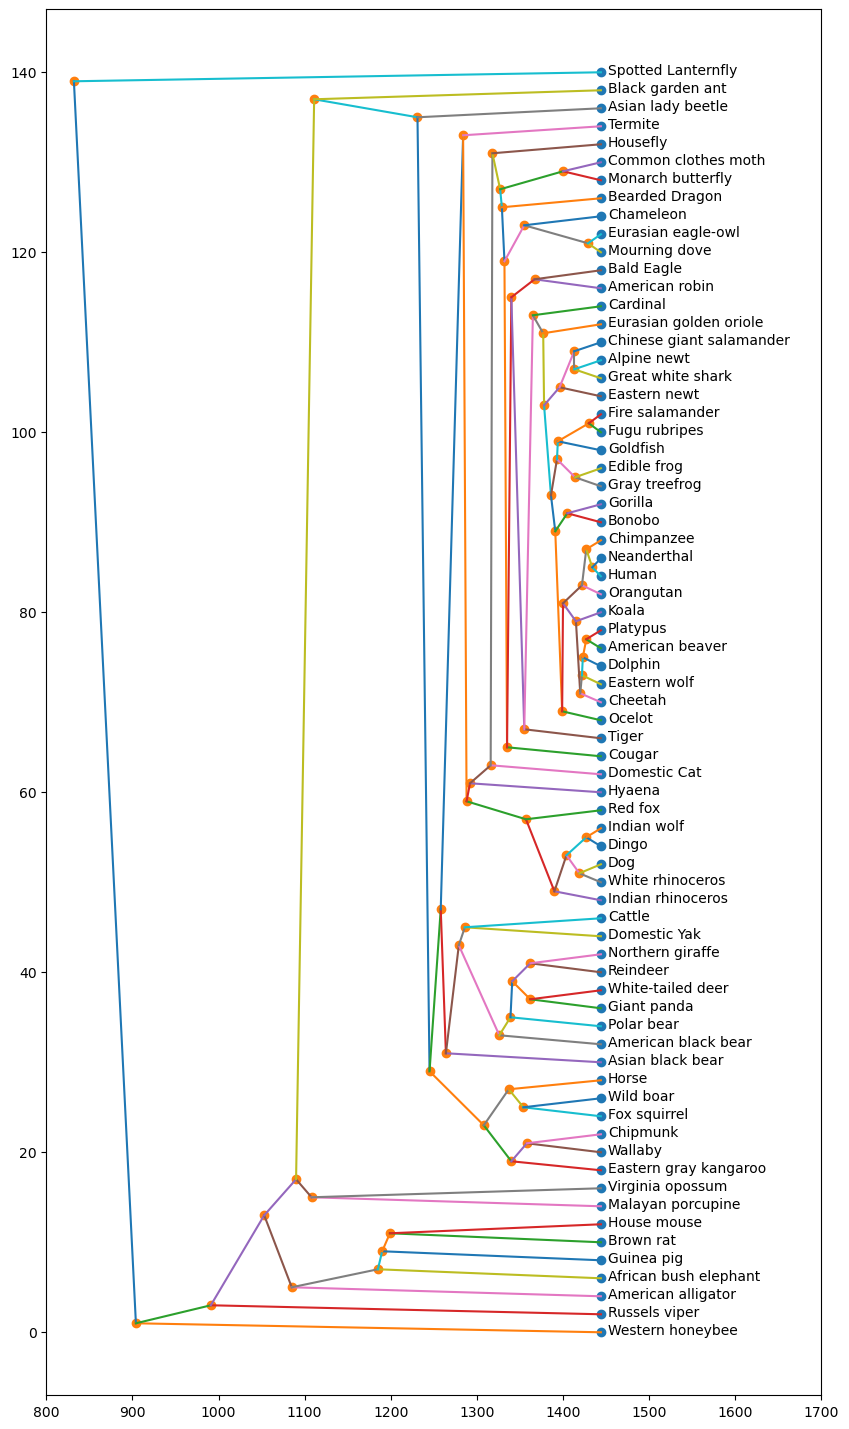

In [19]:
import matplotlib
import matplotlib.pyplot

matplotlib.pyplot.figure(figsize = (10,18))
matplotlib.pyplot.xlim(800,1700)
sp = matplotlib.pyplot.subplot()
# This creates a 10 by 18 space for the graph to be placed, and limits the x axis to cover 800 through 1700 
### Based on the order of magnitude, what do you think the x-axis is?: 

n.inorder(True)
# This runs an inorder traversal on the tree and assigns each node its order within the tree

dlist = n.points(animals_leaves_list, int(pairs[0][1])+10)
# This finds the points for the tree by recursively traversing the tree and collecting their similarity scores 
# and inorder traversal order (x and y respectively)

x = [i[0] for i in dlist]
y = [i[1] for i in dlist]
# Separates out the x and y

sp.scatter([int(pairs[0][1])+10 for i in n.all_leaves()],[2*n.all_leaves().index(i) for i in n.all_leaves()]) 
# places all the leaf nodes (the animals)
for i in range(len(n.all_leaves())):
    sp.text(pairs[0][1]+18,i*2-0.2,n.all_leaves()[i])
# labels all the animals

sp.scatter(x,y)
# 
l = n.draw_lines()
#lists all the connections
x = l[0]
y = l[1]
#What do the above lines do?:
lines = []
#
for i in range(len(x)):
    lines.append([(x[i][j],y[i][j]) for j in range(len(x[j]))])
for i in range(len(lines)):
    sp.plot(np.linspace(lines[i][0][0],lines[i][1][0]),np.linspace(lines[i][0][1],lines[i][1][1]))

